In [11]:
import pandas as pd


from sklearn.metrics import confusion_matrix # 混合行列
from sklearn.model_selection import train_test_split

# 図やグラフを図示するためのライブラリをインポートする。
%matplotlib inline
import matplotlib.pyplot as plt

import optuna

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA #主成分分析
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from lightgbm import LGBMClassifier #LGBM
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ



In [12]:
# データの読み込み
data = pd.read_csv('../../data/learning_data.csv',index_col=0)

# 特徴量とターゲット変数の分割
X = data.drop('dengue', axis=1)  
y = data['dengue']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

最適化ハイパーパラメータ

In [15]:
names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree","Random Forest","LGBM","AdaBoost", "Naive Bayes"]

classifiers = [
    LogisticRegression(class_weight='balanced'),
    SVC(kernel="rbf",class_weight='balanced',probability=True),
    KNeighborsClassifier(),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    LGBMClassifier(class_weight='balanced'),
    AdaBoostClassifier(),
    GaussianNB()]

In [16]:
result = []
for name, clf in zip(names, classifiers): # 指定した複数の分類機を順番に呼び出す
    clf.fit(X_train, y_train) # 学習
    score1 = clf.score(X_train, y_train) # 正解率（train）の算出
    score2 = clf.score(X_test, y_test) # 正解率（test）の算出
    result.append([score1, score2]) # 結果の格納

# test の正解率の大きい順に並べる
result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort_values('test', ascending=False)


[LightGBM] [Info] Number of positive: 2425, number of negative: 5083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 7508, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Axes: >

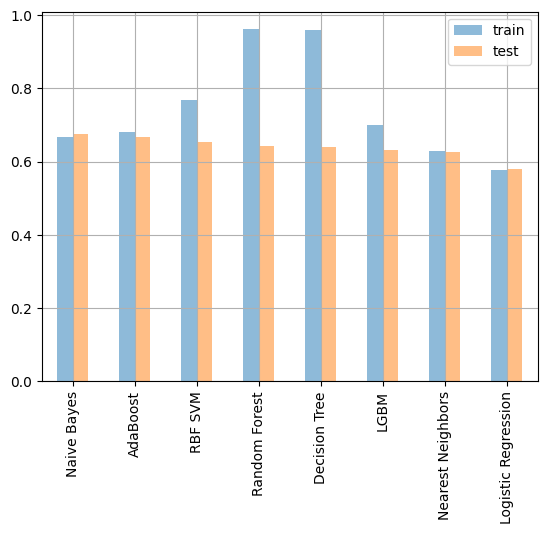

In [17]:
 #棒グラフの描画
result.plot(kind='bar', alpha=0.5, grid=True)


スタッキング

スタッキングモデルの最適化

In [18]:
def object_stacking(trial):
    # 使用するモデル名と分類器を定義
    names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", "Decision Tree", "Random Forest"]

    classifiers = [LogisticRegression(class_weight='balanced'),
                   SVC(kernel="rbf",class_weight='balanced',probability=True),
                   KNeighborsClassifier(),
                   DecisionTreeClassifier(class_weight='balanced'),
                   RandomForestClassifier(class_weight='balanced')
                   ]

    # 弱分類機
    estimators = [(name, clf) for name, clf in zip(names, classifiers)]

    # メタモデル
    num_leaves = trial.suggest_int('num_leaves', 10, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    lambda_l1=trial.suggest_float('lambda_l1', 0.0001, 100)
    lambda_l2=trial.suggest_float('lambda_l2', 0.0001, 100)
    meta_model = LGBMClassifier(num_leaves=num_leaves,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                lambda_l1=lambda_l1,
                                lambda_l2=lambda_l2,
                                class_weight='balanced')

    # スタッキングの定義
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)
    
    score = cross_val_score(stacking_clf, X_train, y_train, cv=3).mean()
    
    return  score



In [19]:
# Optunaによる最適化の実行
study = optuna.create_study(direction='maximize')
study.optimize(object_stacking, n_trials=50)

# 最適なハイパーパラメータを表示
print("Best parameters: ", study.best_params)

[I 2024-11-18 16:48:16,971] A new study created in memory with name: no-name-2bebbf3c-c51b-407e-87c9-1029c023d097


[LightGBM] [Warning] lambda_l2 is set=32.402362642942585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.402362642942585
[LightGBM] [Warning] lambda_l1 is set=39.972866900357694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=39.972866900357694
[LightGBM] [Warning] lambda_l2 is set=32.402362642942585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.402362642942585
[LightGBM] [Warning] lambda_l1 is set=39.972866900357694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=39.972866900357694
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 5005, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training

[I 2024-11-18 16:49:34,957] Trial 0 finished with value: 0.6169408859648199 and parameters: {'num_leaves': 256, 'learning_rate': 0.0005464234506344283, 'n_estimators': 665, 'lambda_l1': 39.972866900357694, 'lambda_l2': 32.402362642942585}. Best is trial 0 with value: 0.6169408859648199.


[LightGBM] [Warning] lambda_l2 is set=32.402362642942585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.402362642942585
[LightGBM] [Warning] lambda_l1 is set=39.972866900357694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=39.972866900357694
[LightGBM] [Warning] lambda_l2 is set=34.25195749145248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.25195749145248
[LightGBM] [Warning] lambda_l1 is set=24.612776526010485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=24.612776526010485
[LightGBM] [Warning] lambda_l2 is set=34.25195749145248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.25195749145248
[LightGBM] [Warning] lambda_l1 is set=24.612776526010485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=24.612776526010485
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009721 seconds.
You can set `force_row_wise=tr

[I 2024-11-18 16:50:54,862] Trial 1 finished with value: 0.6278634037769119 and parameters: {'num_leaves': 837, 'learning_rate': 0.06264198982321603, 'n_estimators': 839, 'lambda_l1': 24.612776526010485, 'lambda_l2': 34.25195749145248}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=34.25195749145248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.25195749145248
[LightGBM] [Warning] lambda_l1 is set=24.612776526010485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=24.612776526010485
[LightGBM] [Warning] lambda_l2 is set=75.86421195414256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.86421195414256
[LightGBM] [Warning] lambda_l1 is set=74.73190452809732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=74.73190452809732
[LightGBM] [Warning] lambda_l2 is set=75.86421195414256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.86421195414256
[LightGBM] [Warning] lambda_l1 is set=74.73190452809732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=74.73190452809732
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to

[I 2024-11-18 16:52:20,981] Trial 2 finished with value: 0.6275964180047625 and parameters: {'num_leaves': 124, 'learning_rate': 0.08893591449883563, 'n_estimators': 687, 'lambda_l1': 74.73190452809732, 'lambda_l2': 75.86421195414256}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=75.86421195414256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.86421195414256
[LightGBM] [Warning] lambda_l1 is set=74.73190452809732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=74.73190452809732
[LightGBM] [Warning] lambda_l2 is set=32.8777768240257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.8777768240257
[LightGBM] [Warning] lambda_l1 is set=38.26131291689466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=38.26131291689466
[LightGBM] [Warning] lambda_l2 is set=32.8777768240257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.8777768240257
[LightGBM] [Warning] lambda_l1 is set=38.26131291689466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=38.26131291689466
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019040 seconds.
You can set `force_col_wise=true` to remov

[I 2024-11-18 16:53:32,754] Trial 3 finished with value: 0.6245331075664172 and parameters: {'num_leaves': 631, 'learning_rate': 0.03719471056267577, 'n_estimators': 205, 'lambda_l1': 38.26131291689466, 'lambda_l2': 32.8777768240257}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=32.8777768240257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.8777768240257
[LightGBM] [Warning] lambda_l1 is set=38.26131291689466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=38.26131291689466
[LightGBM] [Warning] lambda_l2 is set=98.38625652406535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98.38625652406535
[LightGBM] [Warning] lambda_l1 is set=91.0744342506821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=91.0744342506821
[LightGBM] [Warning] lambda_l2 is set=98.38625652406535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98.38625652406535
[LightGBM] [Warning] lambda_l1 is set=91.0744342506821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=91.0744342506821
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036013 seconds.
You can set `force_col_wise=true` to remove 

[I 2024-11-18 16:54:55,804] Trial 4 finished with value: 0.6278626586013117 and parameters: {'num_leaves': 958, 'learning_rate': 0.07066052509399663, 'n_estimators': 463, 'lambda_l1': 91.0744342506821, 'lambda_l2': 98.38625652406535}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=98.38625652406535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98.38625652406535
[LightGBM] [Warning] lambda_l1 is set=91.0744342506821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=91.0744342506821
[LightGBM] [Warning] lambda_l2 is set=77.0937913543342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.0937913543342
[LightGBM] [Warning] lambda_l1 is set=93.0963043939858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=93.0963043939858
[LightGBM] [Warning] lambda_l2 is set=77.0937913543342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.0937913543342
[LightGBM] [Warning] lambda_l1 is set=93.0963043939858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=93.0963043939858
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025262 seconds.
You can set `force_col_wise=true` to remove the 

[I 2024-11-18 16:56:25,817] Trial 5 finished with value: 0.6267970574931718 and parameters: {'num_leaves': 351, 'learning_rate': 0.02107214930618321, 'n_estimators': 934, 'lambda_l1': 93.0963043939858, 'lambda_l2': 77.0937913543342}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=77.0937913543342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.0937913543342
[LightGBM] [Warning] lambda_l1 is set=93.0963043939858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=93.0963043939858
[LightGBM] [Warning] lambda_l2 is set=45.780068353269556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.780068353269556
[LightGBM] [Warning] lambda_l1 is set=47.40275791604304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=47.40275791604304
[LightGBM] [Warning] lambda_l2 is set=45.780068353269556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.780068353269556
[LightGBM] [Warning] lambda_l1 is set=47.40275791604304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=47.40275791604304
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011340 seconds.
You can set `force_col_wise=true` to r

[I 2024-11-18 16:57:50,982] Trial 6 finished with value: 0.6198712357853763 and parameters: {'num_leaves': 755, 'learning_rate': 0.04173222404973549, 'n_estimators': 20, 'lambda_l1': 47.40275791604304, 'lambda_l2': 45.780068353269556}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=45.780068353269556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.780068353269556
[LightGBM] [Warning] lambda_l1 is set=47.40275791604304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=47.40275791604304
[LightGBM] [Warning] lambda_l2 is set=10.551997547899749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.551997547899749
[LightGBM] [Warning] lambda_l1 is set=70.68547461662286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.68547461662286
[LightGBM] [Warning] lambda_l2 is set=10.551997547899749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.551997547899749
[LightGBM] [Warning] lambda_l1 is set=70.68547461662286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.68547461662286
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010176 seconds.
You can set `force_row_wise=true

[I 2024-11-18 16:59:35,404] Trial 7 finished with value: 0.6243997743608283 and parameters: {'num_leaves': 641, 'learning_rate': 0.0837480388426821, 'n_estimators': 492, 'lambda_l1': 70.68547461662286, 'lambda_l2': 10.551997547899749}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=10.551997547899749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.551997547899749
[LightGBM] [Warning] lambda_l1 is set=70.68547461662286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.68547461662286
[LightGBM] [Warning] lambda_l2 is set=43.243747972116964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.243747972116964
[LightGBM] [Warning] lambda_l1 is set=41.63221177677421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=41.63221177677421
[LightGBM] [Warning] lambda_l2 is set=43.243747972116964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.243747972116964
[LightGBM] [Warning] lambda_l1 is set=41.63221177677421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=41.63221177677421
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true

[I 2024-11-18 17:01:30,204] Trial 8 finished with value: 0.6250657484400016 and parameters: {'num_leaves': 535, 'learning_rate': 0.08108352771185759, 'n_estimators': 916, 'lambda_l1': 41.63221177677421, 'lambda_l2': 43.243747972116964}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=43.243747972116964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.243747972116964
[LightGBM] [Warning] lambda_l1 is set=41.63221177677421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=41.63221177677421
[LightGBM] [Warning] lambda_l2 is set=1.1909553319996422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1909553319996422
[LightGBM] [Warning] lambda_l1 is set=49.162653881560956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=49.162653881560956
[LightGBM] [Warning] lambda_l2 is set=1.1909553319996422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1909553319996422
[LightGBM] [Warning] lambda_l1 is set=49.162653881560956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=49.162653881560956
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=

[I 2024-11-18 17:02:50,353] Trial 9 finished with value: 0.6261315624554559 and parameters: {'num_leaves': 339, 'learning_rate': 0.03257271406894653, 'n_estimators': 495, 'lambda_l1': 49.162653881560956, 'lambda_l2': 1.1909553319996422}. Best is trial 1 with value: 0.6278634037769119.


[LightGBM] [Warning] lambda_l2 is set=1.1909553319996422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1909553319996422
[LightGBM] [Warning] lambda_l1 is set=49.162653881560956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=49.162653881560956
[LightGBM] [Warning] lambda_l2 is set=19.955039542268715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.955039542268715
[LightGBM] [Warning] lambda_l1 is set=3.758984339180955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.758984339180955
[LightGBM] [Warning] lambda_l2 is set=19.955039542268715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.955039542268715
[LightGBM] [Warning] lambda_l1 is set=3.758984339180955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.758984339180955
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=tr

[I 2024-11-18 17:04:12,071] Trial 10 finished with value: 0.6365195232281348 and parameters: {'num_leaves': 977, 'learning_rate': 0.060726182966831924, 'n_estimators': 754, 'lambda_l1': 3.758984339180955, 'lambda_l2': 19.955039542268715}. Best is trial 10 with value: 0.6365195232281348.


[LightGBM] [Warning] lambda_l2 is set=19.955039542268715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.955039542268715
[LightGBM] [Warning] lambda_l1 is set=3.758984339180955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.758984339180955
[LightGBM] [Warning] lambda_l2 is set=22.99827204587298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.99827204587298
[LightGBM] [Warning] lambda_l1 is set=4.104983399628431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.104983399628431
[LightGBM] [Warning] lambda_l2 is set=22.99827204587298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.99827204587298
[LightGBM] [Warning] lambda_l1 is set=4.104983399628431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.104983399628431
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to

[I 2024-11-18 17:05:33,851] Trial 11 finished with value: 0.6329239977308339 and parameters: {'num_leaves': 969, 'learning_rate': 0.06069659712681563, 'n_estimators': 751, 'lambda_l1': 4.104983399628431, 'lambda_l2': 22.99827204587298}. Best is trial 10 with value: 0.6365195232281348.


[LightGBM] [Warning] lambda_l2 is set=22.99827204587298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.99827204587298
[LightGBM] [Warning] lambda_l1 is set=4.104983399628431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.104983399628431
[LightGBM] [Warning] lambda_l2 is set=14.976866354613186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.976866354613186
[LightGBM] [Warning] lambda_l1 is set=2.7799174160729194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7799174160729194
[LightGBM] [Warning] lambda_l2 is set=14.976866354613186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.976866354613186
[LightGBM] [Warning] lambda_l1 is set=2.7799174160729194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7799174160729194
[LightGBM] [Info] Number of positive: 1616, number of negative: 3389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=tr

[W 2024-11-18 17:17:59,294] Trial 12 failed with parameters: {'num_leaves': 995, 'learning_rate': 0.057085553349085834, 'n_estimators': 704, 'lambda_l1': 2.7799174160729194, 'lambda_l2': 14.976866354613186} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_22766/3344879645.py", line 31, in object_stacking
    score = cross_val_score(stacking_clf, X_train, y_train, cv=3).mean()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", l

KeyboardInterrupt: 

In [ ]:
# 予測
y_pred = stacking_clf.predict(X_test)

# 精度の表示
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")


#可視化の準備
stacking_score1 = stacking_clf.score(X_train, y_train)  
stacking_score2 = stacking_clf.score(X_test, y_test)    

# スタッキング結果を DataFrame に追加
stacking_result = pd.DataFrame([[stacking_score1, stacking_score2]], columns=['train', 'test'], index=['Stacking'])

# 既存の結果とスタッキング結果を結合
result_df = pd.concat([pd.DataFrame(result, columns=['train', 'test'], index=names), stacking_result])

# test の正解率の大きい順に並べる
result_df = result_df.sort_values('test', ascending=False)




In [54]:
# 結果の表示
print(result_df)


                        train      test
RBF SVM              0.678827  0.634498
Nearest Neighbors    0.668404  0.630699
Decision Tree        0.664169  0.623860
Random Forest        0.648534  0.621581
Logistic Regression  0.635831  0.614742
Stacking             0.663844  0.607143


<Axes: >

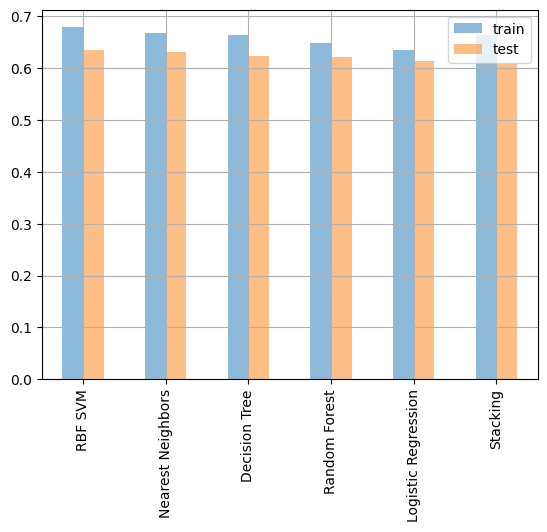

In [55]:
result_df.plot(kind='bar', alpha=0.5, grid=True)